# Tinanic Survival

*__Note__: _Dataset has been obtained from kaggle.com_

## Loading Data

To begin with, the train and test datasets are loaded using the tools provided by pandas and both of these datasets are concatenated in only one. That will ease the way we can work with the information.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
data = pd.concat([train, test]).reset_index(drop=True)

#size of training dataset
train_samples = train.shape[0]

#print some of them
data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [2]:
#show the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## Data Analysis

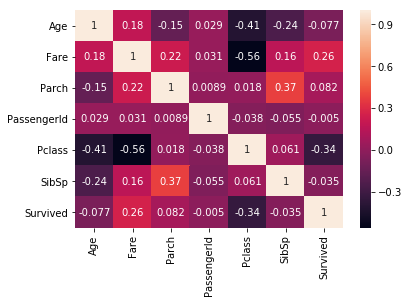

In [3]:
#heatmap
#fig = plt.figure(figsize=(9, 7))
sns.heatmap(data.corr(), annot=True);

At first sight we see the most correlated features with 'Survived' are 'Pclass' and 'Fare'.

In [4]:
data.groupby(data.Survived).Survived.count()

Survived
0.0    549
1.0    342
Name: Survived, dtype: int64

__There are more non-survivors__ than survivors so we will have to deal with it.

## Data Engineering
### Dropping

There are a few number of features that can be removed. Apparently things like the ticket, the passenger ID or their names should not be relevant. At least in the way a passenger can survive or not.

In [5]:
#Dropping useless features
data = data.drop(['Name', 'PassengerId', 'Ticket'], axis=1)
data.head(10)

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
0,22.0,NaN,S,7.2500,0,3,male,1,0.0
1,38.0,C85,C,71.2833,0,1,female,1,1.0
2,26.0,NaN,S,7.9250,0,3,female,0,1.0
3,35.0,C123,S,53.1000,0,1,female,1,1.0
4,35.0,NaN,S,8.0500,0,3,male,0,0.0
5,NaN,NaN,Q,8.4583,0,3,male,0,0.0
6,54.0,E46,S,51.8625,0,1,male,0,0.0
7,2.0,NaN,S,21.0750,1,3,male,3,0.0
8,27.0,NaN,S,11.1333,2,3,female,0,1.0
9,14.0,NaN,C,30.0708,0,2,female,1,1.0


### Cabin

The cabin is formed by a letter with numbers and some cases there are more than one. So we can extract the letter to know the importance and localization of the passenger inside the ship. [Here](https://commons.wikimedia.org/wiki/File:Titanic_cutaway_diagram.png) you have the real deck distribution.

Empty values will be set to zero.

In [6]:
data.Cabin.head(5)

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [7]:
# Cabin
data.Cabin.fillna('0', inplace=True)
data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8

In [8]:
# Change the type from object to int
data.Cabin = pd.to_numeric(data.Cabin)

Now we can show how this feature is related to the survival in the train dataset.

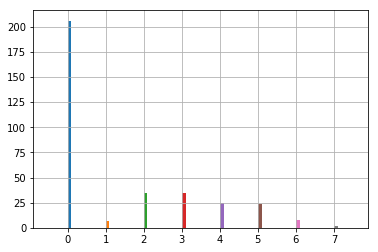

In [9]:
data[data.Survived==1].groupby(data.Cabin).Cabin.hist();

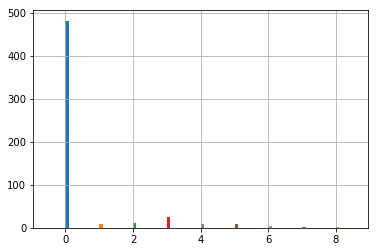

In [10]:
data[data.Survived==0].groupby(data.Cabin).Cabin.hist();

In [11]:
data[data.Cabin==0].Cabin.count()/data.Cabin.count()

0.77463712757830405

Another problem, the 77% of the cabins were unknown.. But seeing the previous graphs we can assume that is likely the passenger dies if the cabin is unknown.

So we can transform the Cabin to a binary classification.

In [12]:
data.loc[data.Cabin != 0, 'Cabin'] = 1

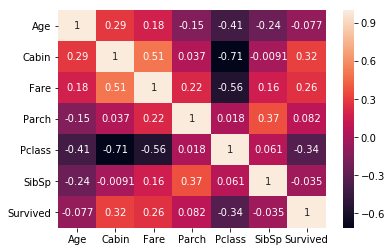

In [13]:
sns.heatmap(data.corr(), annot=True);

### Embarked

/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


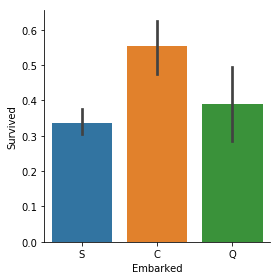

In [14]:
g  = sns.factorplot(x="Embarked",y="Survived",kind="bar",data=data)

In [15]:
# Embarked
data.loc[data.Embarked == 'C', 'Embarked'] = 1
data.loc[data.Embarked == 'Q', 'Embarked'] = 2
data.loc[data.Embarked == 'S', 'Embarked'] = 3

In [16]:
data[data.Embarked.isna()]

,Age,Cabin,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived
61,38.0,1,NaN,80.0,0,1,female,0,1.0
829,62.0,1,NaN,80.0,0,1,female,0,1.0


In [17]:
# They are females of the first class and survivors -> assumption: they embarked in C
data.Embarked.fillna(1, inplace=True)

### Family Size

Obviously the family size is quite important because it can affect directly if a person gets survived or not. The dataset has two features related to this meaning, 'SibSp' and 'Parch'. The first one is 'siblings and spouse' and the second one means 'parents and child'. Both features are defined as numbers so they can be transformed to a new one which represents the size of the family. It's only necessary to sum both of them and asign the correspondent size. It's going to be taken the following sizes: 'alone', 'medium' (1-4) and 'large' (more than 4).

After that, the original features will be deleted.

In [18]:
#New column to know if the passenger has family on board
def family(size):
    if size == 0:
        return "alone"
    elif size < 5:
        return "medium"
    else:
        return "large"

data['FamilySize'] = (data['SibSp']+data['Parch']).apply(family)
data = data.drop(['SibSp', 'Parch'], axis=1)

data.head()

,Age,Cabin,Embarked,Fare,Pclass,Sex,Survived,FamilySize
0,22.0,0,3,7.2500,3,male,0.0,medium
1,38.0,1,1,71.2833,1,female,1.0,medium
2,26.0,0,3,7.9250,3,female,1.0,alone
3,35.0,1,3,53.1000,1,female,1.0,medium
4,35.0,0,3,8.0500,3,male,0.0,alone


### Filling 'Age' NaN with Mean

Train and test datasets have many rows with empty values. In order to avoid that, the mean of every feature will be taken and use it to fill in the blanks.

In [19]:
cond = (data['Sex']=='female') & (data['Pclass']==3)
data.groupby(['Survived','Sex','Pclass'])['Age'].mean()
data[cond].groupby(['Sex','Pclass'])['Age'].mean()

Sex     Pclass
female  3         22.185329
Name: Age, dtype: float64

In the case of __age__ is not that easy. There could be a little correlation between the class where the passenger is traveling, the gender of it and if the passenger has survived or not. So it's a big deal to take into account these three features to calculate the most likely age.

In [20]:
def getAge(row):
    surv = row.Survived
    sex = row.Sex
    pclass = row.Pclass
    
    if surv==0 or surv==1:
        condition = (data['Survived']==surv) & (data['Sex']==sex) & (data['Pclass']==pclass)
        df_mean = data[condition].groupby(['Survived','Sex','Pclass'])['Age'].mean()
    else:
        condition = (data['Sex']==sex) & (data['Pclass']==pclass)
        df_mean = data[condition].groupby(['Sex','Pclass'])['Age'].mean()
    
    #print("surv: {}, sex: {}, class: {} -> age (mean): {}".format(surv, sex, pclass, df_mean.mean()))
    return df_mean.mean()
    
data['Age'] = data['Age'].fillna(data.apply(getAge, axis=1))

In [21]:
len(data['Age']) - data['Age'].count()

0

### 'Fare' Distribution

Showing the 'Fare' distribution we observe the feature is skewed (to the right). So we can manage it applying the log to all the values. This is useful when the range of values has the minimum in 0, in other cases the log for negative numbers is a problem. 

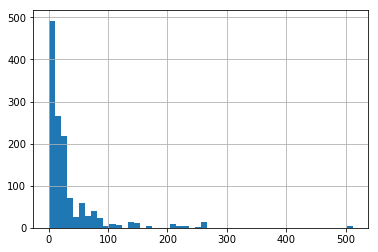

In [22]:
data.Fare.hist(bins=50)

In [23]:
d1 = data["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

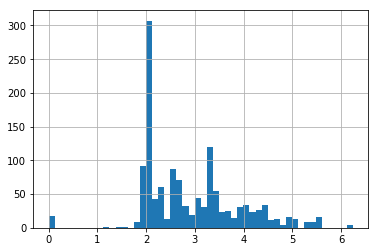

In [24]:
d1.hist(bins=50)

### Filling 'Fare' NaN with Mean

In [25]:
data['Fare'] = data['Fare'].fillna(data['Fare'].mean())

### Age Range: Grouping

Similar to the 'familty size' (engineered feature), the age can be represented and categorized. The possible classes are going to be: __child__, __young__, __adult__ and __old__.

In [26]:
#define age by ranges
def getAgeRange(age):
    if age < 5:
        return "child"
    elif age < 20:
        return "young"
    elif age < 50:
        return "adult"
    else:
        return "old"

data['Age'] = data['Age'].apply(getAgeRange)

In [27]:
# Age distribution
data.groupby(['Age'])['Survived'].describe()

,count,mean,std,min,25%,50%,75%,max
Age,,,,,,,,
adult,626.0,0.333866,0.471970,0.0,0.0,0.0,1.0,1.0
child,40.0,0.675000,0.474342,0.0,0.0,1.0,1.0,1.0
old,74.0,0.364865,0.484678,0.0,0.0,0.0,1.0,1.0
young,151.0,0.523179,0.501125,0.0,0.0,1.0,1.0,1.0


### Getting Feature Dummies

The features that are categorical have to be converted to dummies. On this way we'll have new "numerical" features.

In [28]:
#Transform categorical to dummies
data = pd.get_dummies(data)

### Function to Remove Anomalies

In [29]:
from sklearn.covariance import EllipticEnvelope

def idxAnomalies(X):
    ee = EllipticEnvelope(contamination=0.05,
                          assume_centered=True,
                          random_state=13)
    ee.fit(X)
    pred = ee.predict(X)

    return [index[0] for index, x in np.ndenumerate(pred) if x != 1]


### Checking NaN

Only the test dataset should have _NaN_ values for the 'Survived' column.

In [30]:
#finding NaN
data.columns[data.isnull().any()].tolist()

['Survived']

### Normalizing

Probably the range of numerical features are not the same and this could produce problems in our results. A proper way to get good calculations is normalizing all the features.

In this case we're going to use the __minmax scaler__ because it transforms the range of the features to values between 0 to 1.

In [31]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cabin,1309.0,0.225363,0.417981,0.0,0.0000,0.0000,0.000,1.0000
Embarked,1309.0,2.490451,0.816089,1.0,2.0000,3.0000,3.000,3.0000
Fare,1309.0,33.295479,51.738879,0.0,7.8958,14.4542,31.275,512.3292
Pclass,1309.0,2.294882,0.837836,1.0,2.0000,3.0000,3.000,3.0000
Survived,891.0,0.383838,0.486592,0.0,0.0000,0.0000,1.000,1.0000
Age_adult,1309.0,0.723453,0.447461,0.0,0.0000,1.0000,1.000,1.0000
Age_child,1309.0,0.038961,0.193576,0.0,0.0000,0.0000,0.000,1.0000
Age_old,1309.0,0.084034,0.277544,0.0,0.0000,0.0000,0.000,1.0000
Age_young,1309.0,0.153552,0.360657,0.0,0.0000,0.0000,0.000,1.0000
Sex_female,1309.0,0.355997,0.478997,0.0,0.0000,0.0000,1.000,1.0000


Avoiding the dummy features, we see 'pclass' is not moving between a range of (0,1).

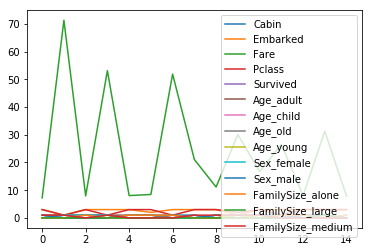

In [32]:
import matplotlib.pyplot as plt

data.head(15).plot()
plt.show()

After the scaler processing we'll have all the features in the same range. This speeds up the calculations because all are small numbers which are easy to use (better performance).

The picture below shows the features ranges.

Train shape: (1309, 14)


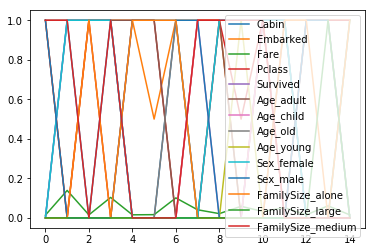

,count,mean,std,min,25%,50%,75%,max
Cabin,1309.0,0.225363,0.417981,0.0,0.000000,0.000000,0.000000,1.0
Embarked,1309.0,0.745225,0.408045,0.0,0.500000,1.000000,1.000000,1.0
Fare,1309.0,0.064988,0.100988,0.0,0.015412,0.028213,0.061045,1.0
Pclass,1309.0,0.647441,0.418918,0.0,0.500000,1.000000,1.000000,1.0
Survived,891.0,0.383838,0.486592,0.0,0.000000,0.000000,1.000000,1.0
Age_adult,1309.0,0.723453,0.447461,0.0,0.000000,1.000000,1.000000,1.0
Age_child,1309.0,0.038961,0.193576,0.0,0.000000,0.000000,0.000000,1.0
Age_old,1309.0,0.084034,0.277544,0.0,0.000000,0.000000,0.000000,1.0
Age_young,1309.0,0.153552,0.360657,0.0,0.000000,0.000000,0.000000,1.0
Sex_female,1309.0,0.355997,0.478997,0.0,0.000000,0.000000,1.000000,1.0


In [33]:
#Squeeze the data to [0,1]
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
data[['Pclass']] = scaler.fit_transform(data[['Pclass']])
data[['Fare']] = scaler.fit_transform(data[['Fare']])
data[['Cabin']] = scaler.fit_transform(data[['Cabin']])
data[['Embarked']] = scaler.fit_transform(data[['Embarked']])
print("Train shape: {}".format(data.shape))

data.head(15).plot()
plt.show()
data.describe().T

### Splitting the data to train and test

As a good practive, we're going to split the data into two different datasets, training and testing. Taking the number of training samples (saved in the beginning) we are able to split it.

Besides, we'll use the __k-fold__ method to get different batches of the data (it's configured with 3 splits).

#### StratifiedKFold training set

In [34]:
from sklearn.model_selection import StratifiedKFold

y = np.array(data['Survived'])
X = np.array(data.drop('Survived', axis=1))

#split by idx
idx = train_samples
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

# Remove anomalies only in train dataset
idx_anomalies = idxAnomalies(X_train)
X_train = np.delete(X_train, idx_anomalies, axis=0)
y_train = np.delete(y_train, idx_anomalies, axis=0)

print("Shape train: {}".format(X_train.shape))
print("Shape test: {}".format(X_test.shape))
#print(y_train[0:1])
#print(X_train[0:1].tolist())

kf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
print(kf)

/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/sklearn/covariance/robust_covariance.py:622: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


Shape train: (846, 13)
Shape test: (418, 13)
StratifiedKFold(n_splits=3, random_state=42, shuffle=True)


#### Grid Search

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

rf = RandomForestClassifier(random_state=42)
rf_param_grid = {"max_depth": [3, 5, 8],
              "min_samples_split": [3, 10, 20],
              "min_samples_leaf": [3, 10, 20],
              "n_estimators" :[10, 20, 30, 40, 50]}

gsrf = GridSearchCV(rf, param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsrf.fit(X_train, y_train)

# Best score
gsrf.best_score_

Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=4)]: Done 212 tasks      | elapsed:    5.1s
[Parallel(n_jobs=4)]: Done 1112 tasks      | elapsed:   26.8s
[Parallel(n_jobs=4)]: Done 1350 out of 1350 | elapsed:   32.6s finished


0.84042553191489366

In [36]:
brf = gsrf.best_estimator_
gsrf.best_params_

{'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 20,
 'n_estimators': 10}

In [63]:
from sklearn.svm import SVC

svc = SVC(random_state=42, probability=True)

Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
gammas = [0.0001, 0.001, 0.01, 0.1, 1]
    
svc_param_grid = [{'kernel': ['rbf'], 'gamma': gammas, 'C': Cs}]

gssvc = GridSearchCV(svc, param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gssvc.fit(X_train, y_train)

# Best score
gssvc.best_score_

Fitting 10 folds for each of 35 candidates, totalling 350 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 350 out of 350 | elapsed:   19.5s finished


0.82624113475177308

In [64]:
bsvc = gssvc.best_estimator_
gssvc.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

#### Voting Ensemble

Although it had been configured an ensemble method with a few classifiers (all have the same weight), it was seen the accuracy was bigger when the random forest classifier was used alone.

For this reason, part of the previous code is commented and 'clf2' is used.

In [65]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

eclf = VotingClassifier(estimators=[('rf', brf), ('svc', bsvc)], voting='soft')

epoch = 1
for train_idx, val_idx in kf.split(X_train, y_train):
    X_t, X_v = X_train[train_idx], X_train[val_idx]
    y_t, y_v = y_train[train_idx], y_train[val_idx]
    
    epoch += 1
    eclf.fit(X_t, y_t)
    scores = cross_val_score(eclf, X_v, y_v)
    print("Scores({}): {}".format(epoch-1, scores))


Scores(1): [ 0.8         0.78947368  0.80645161]
Scores(2): [ 0.78947368  0.88297872  0.78494624]
Scores(3): [ 0.76842105  0.8172043   0.76344086]


### Learning Curve

<module 'matplotlib.pyplot' from '/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/pyplot.py'>

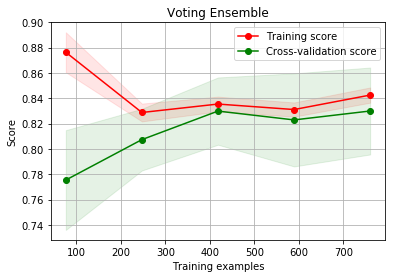

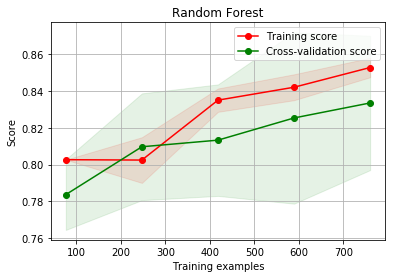

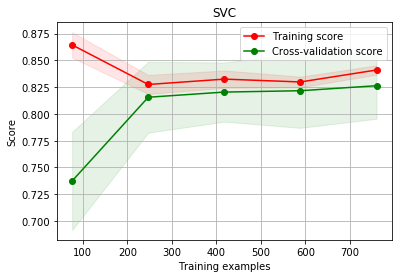

In [66]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

#
plot_learning_curve(eclf, "Voting Ensemble", X_train, y_train, cv=kfold, n_jobs=4)
plot_learning_curve(brf, "Random Forest", X_train, y_train, cv=kfold, n_jobs=4)
plot_learning_curve(bsvc, "SVC", X_train, y_train, cv=kfold, n_jobs=4)

### Post-Analysis

Finally, we only need to print the classification report and the confusion matrix and see the outcome.

[[510  25]
 [110 201]]


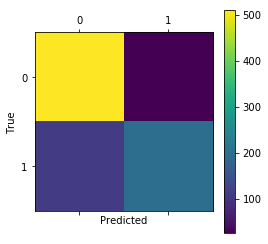

In [71]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = eclf.predict(X_train)
cm = confusion_matrix(y_train, predictions)
print(cm)
plt.matshow(cm)
plt.colorbar()
ax = plt.gca()
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

plt.show()

In [72]:
print(classification_report(y_train, predictions))

             precision    recall  f1-score   support

        0.0       0.82      0.95      0.88       535
        1.0       0.89      0.65      0.75       311

avg / total       0.85      0.84      0.83       846



Seeing the ROC curve and the AUC we can evaluate if the model is a good classifier.

In [73]:
from sklearn.metrics import roc_curve, auc

# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'best')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.title('Receiver Operating Characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

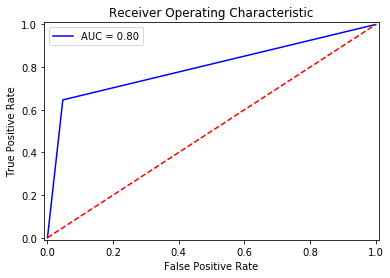

In [74]:
plot_roc_curve(y_train, predictions)

## Get Predictions

*_Note: Following code is not related to the calculations but how to compose the csv required by the Kaggle competition._

In [43]:
import os

predictions = gsrf.best_estimator_.predict(X_test)

passengerId = 892
file = "PassengerId,Survived" + os.linesep

for i in range(len(X_test)):
    file += "{},{}".format(passengerId, (int)(predictions[i]))  + os.linesep
    passengerId += 1

In [44]:
# Save to file
with open('attempt.txt', 'w') as f:
    f.write(file)